## Twitter Sentiment Analysis

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label ‘1’ denotes the tweet is racist/sexist and label ‘0’ denotes the tweet is not racist/sexist, your objective is to predict the labels on the given test dataset.

In [0]:
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt  

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

In [0]:
train  = pd.read_csv(r'C:\Users\Dell\Downloads\train_E6oV3lV.csv') 
test = pd.read_csv(r'C:\Users\Dell\Downloads\test_tweets_anuFYb8.csv')

## Text preprocessing.


### 1.Data Inspection

In [0]:
# checking few non racist/sexist tweets
train[train['label'] == 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
7,8,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,10,0,@user @user welcome here ! i'm it's so #gr8 !


In [0]:
# checking few racist/sexist tweets
train[train['label'] == 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
7,8,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,10,0,@user @user welcome here ! i'm it's so #gr8 !


There are quite a many words and characters which are not really required. So, we will try to keep only those words which are important and add value.

In [0]:
train.shape, test.shape

((31962, 3), (17197, 2))

In [0]:
train["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [0]:
test.head()

,id,tweet,label
0,31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦,0
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why,0
2,31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!,0
3,31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite",0
4,31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦",0


In the train dataset, we have 2,242 (~7%) tweets labeled as racist or sexist, and 29,720 (~93%) tweets labeled as non racist/sexist. So, it is an imbalanced classification dataset

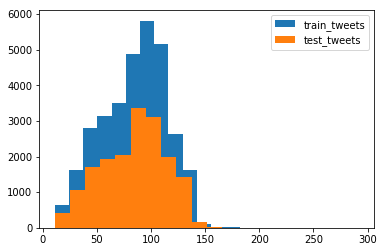

In [0]:
# checking the distribution of length of the tweets, in terms of words, in both train and test data.

length_train = train['tweet'].str.len() 
length_test = test['tweet'].str.len() 
plt.hist(length_train, bins=20, label="train_tweets") 
plt.hist(length_test, bins=20, label="test_tweets") 
plt.legend() 
plt.show()

### Data cleaning

In [0]:
#Combining the train and test dataset
combi = train.append(test, ignore_index=True) 
combi.shape

(49159, 3)

In [0]:
# remove unwanted text patterns from the tweets.
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt  

In [0]:
# 1. Removing Twitter Handles (@user)
# creating a new column tidy_tweet
# passing @[]* as a pattern to remove pattern function.its a RE that will pick any word starting with @
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*") 
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


In [0]:
#2.Removing Punctuations, Numbers, and Special Characters
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ") 
combi.head(10)

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in ur
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,huge fan fare and big talking before they leave chaos and pay disputes when they get there #allshowandnogo
6,7,0.0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,camping tomorrow danny
7,8,0.0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,the next school year is the year for exams can t think about that #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0.0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,we won love the land #allin #cavs #champions #cleveland #clevelandcavaliers
9,10,0.0,@user @user welcome here ! i'm it's so #gr8 !,welcome here i m it s so #gr


In [0]:
# 3.Removing Short Words
#remove all the words having length 3 or less
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


In [0]:
# 4.Text Normalization
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing 
tokenized_tweet.head()

0                [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                     [bihday, your, majesty]
3                                                            [#model, love, take, with, time]
4                                                          [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [0]:
from nltk.stem.porter import * 
stemmer = PorterStemmer() 
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming


let’s stitch these tokens back together. It can easily be done using nltk’s MosesDetokenizer function.

In [0]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])    
combi['tidy_tweet'] = tokenized_tweet

## 1.common words used in the tweets

In [0]:
from wordcloud import WordCloud
all_words = ' '.join([text for text in combi['tidy_tweet']]) 

from above we can see most of words are positive like love,great,happi,smile etc but it doesnt give any idea about words associated with racist tweets.therefore we will plot separate wordcloud for both classes in train data

### 2. Words in non racist/sexist tweets

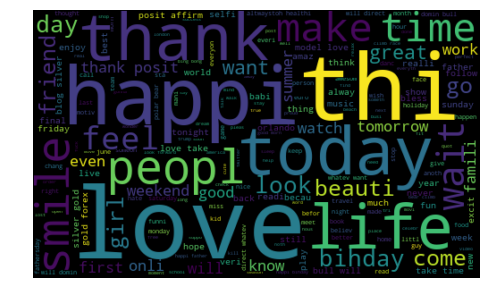

In [0]:
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]]) 
wordcloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(normal_words) 
plt.figure(figsize=(8, 5)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off') 
plt.show()

Most of the frequent words are compatible with the sentiment, i.e, non-racist/sexists tweets.

### 3. Racist/Sexist Tweets

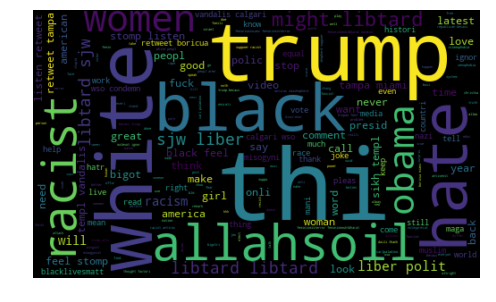

In [0]:
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]]) 
wordcloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(negative_words) 
plt.figure(figsize=(8, 5)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off') 
plt.show()

### 4. impact of Hashtags on tweets sentiment



checking whether these hashtags add any value to our sentiment analysis task, i.e they help in distinguishing tweets into the different sentiments.

We will store all the trend terms in two separate lists — one for non-racist/sexist tweets and the other for racist/sexist tweets.

In [0]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [0]:
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

### Non-Racist/Sexist Tweets

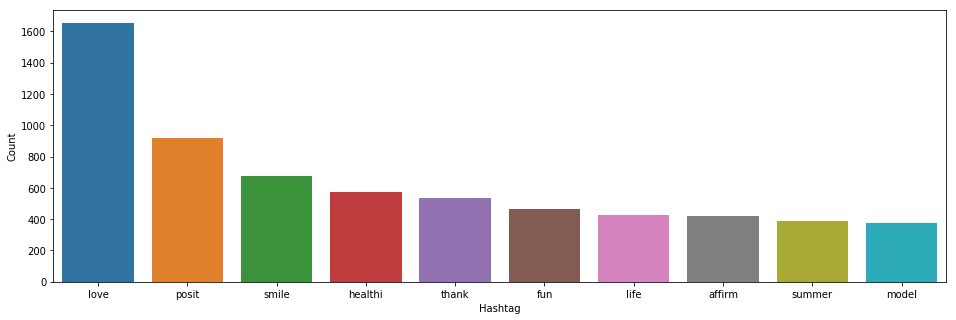

In [0]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [0]:
print(d)

     Hashtag  Count
32      love   1654
39     posit    917
58     smile    676
157  healthi    573
38     thank    534
176      fun    463
343     life    425
92    affirm    423
286   summer    390
4      model    375


### Racist/Sexist Tweets

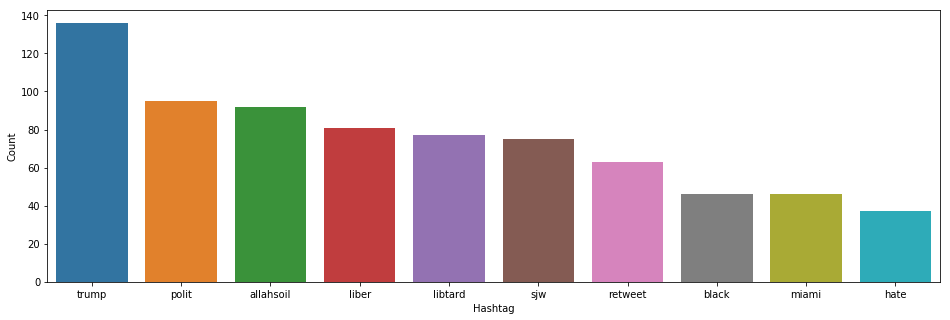

In [0]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [0]:
print(e)

      Hashtag  Count
22      trump    136
31      polit     95
63  allahsoil     92
30      liber     81
28    libtard     77
29        sjw     75
60    retweet     63
59      black     46
62      miami     46
33       hate     37


Now we have to convert Text into vectors/features.

#### 1.BAG OF WORDS

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])
bow.shape

(49159, 1000)

#### 2. TFIDF

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])
tfidf.shape

(49159, 1000)

#### 3.WORD2VEC

In [0]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing 
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34) 

model_w2v.train(tokenized_tweet, total_examples= len(combi['tidy_tweet']), epochs=20)


(6510281, 7536020)

In [0]:
model_w2v.wv.most_similar(positive="dinner")


[('#avocado', 0.5985120534896851),
 ('#biall', 0.5919255018234253),
 ('spaghetti', 0.5806020498275757),
 ('noodl', 0.5749346613883972),
 ('cookout', 0.572480320930481),
 ('#cellar', 0.5676290988922119),
 ('#toast', 0.5650596618652344),
 ('dess', 0.561635434627533),
 ('spinach', 0.5586284399032593),
 ('enrout', 0.5488922595977783)]

In [0]:
model_w2v.wv.most_similar(positive="trump")


[('donald', 0.5646014213562012),
 ('phoni', 0.5530675649642944),
 ('hillari', 0.5496572256088257),
 ('unfit', 0.5430516004562378),
 ('#delegaterevolt', 0.541167140007019),
 ('endors', 0.5317304134368896),
 ('businessman', 0.5280466079711914),
 ('tomlin', 0.5254948139190674),
 ('nomine', 0.525327742099762),
 ('jibe', 0.5252704620361328)]

In [0]:
#vector representation of any word from corpus.
model_w2v['food']

array([ 0.20537156,  0.18613262,  0.38135555,  0.04864233, -0.48271042,
       -0.20205475,  0.32512555,  0.01402179,  0.47565573, -0.20257194,
       -0.45658153, -0.54581904,  0.30528256,  0.08608676, -0.05343911,
        0.1627749 ,  0.33824885, -0.04346388, -0.51884824,  0.9157702 ,
       -0.11581734, -0.09639703,  0.24795845,  0.2617217 , -0.7539403 ,
        0.6679637 , -0.73855585, -0.33526495,  0.20579438, -0.44919977,
        0.03457068, -0.14411938,  0.33926344, -0.3323758 ,  0.20390482,
       -0.65700984, -0.05445968, -0.28781056,  0.856062  ,  0.73436093,
       -0.32885778,  0.06273562, -0.4564438 ,  0.00585121, -0.34239233,
        0.38724524,  0.53964627, -0.30826643, -0.48036045,  0.05654992,
        0.01532195, -0.09037384,  0.11139873,  0.25618654, -0.6066187 ,
       -0.38740534,  0.13534553, -0.07013426,  0.07613499,  0.13990371,
        0.27460754, -0.18515426, -0.18431859,  0.7020854 ,  0.40852508,
        0.234273  , -0.01355959, -0.06468274,  0.1270016 , -0.40

In [0]:
len(model_w2v['food'])

200

From the above two examples, we can see that our word2vec model does a good job of finding the most similar words for a given word

#### Preparing Vectors for Tweets

In [0]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [0]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(49159, 200)

Now we have 200 new features, whereas in Bag of Words and TF-IDF we had 1000 features.



## ML MODELS

We are now done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF and word2vec vectors. We will use the following algorithms to build models:

1.Logistic Regression

2.Support Vector Machine

3.RandomForest

4.Naive Bayes

5.XGBoost

## 1. logistic regression (BOW)

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore") 


train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'],  
                                                          random_state=42, 
                                                          test_size=0.3)# calculating f1 score

In [0]:
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

0.5307820299500832

### logistic regression (tfidf)

In [0]:
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)


0.5446507515473032

#### logistic regression (Word2Vec )

In [0]:
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:] 
xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]
lreg.fit(xtrain_w2v, ytrain) 
prediction = lreg.predict_proba(xvalid_w2v) 
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

0.6101694915254238

## 2.SVM

#### SVM(BOW)

In [0]:
from sklearn import svm

svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain) 
prediction = svc.predict_proba(xvalid_bow) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

0.5088207985143919

#### SVM(TFIDF)


In [0]:
svc = svm.SVC(kernel='linear', 
C=1, probability=True).fit(xtrain_tfidf, ytrain) 
prediction = svc.predict_proba(xvalid_tfidf) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

0.5109489051094891

#### SVM(W2V)


In [0]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain) 
prediction = svc.predict_proba(xvalid_w2v) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)


0.615505090054816

### 3. RANDOM FOREST

#### RANDOM FOREST(BOW)

In [0]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_bow, ytrain) 
prediction = rf.predict(xvalid_bow) 
# validation score 
f1_score(yvalid, prediction)

0.5529225908372828

#### RANDOM FOREST(TFIDF)

In [0]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain) 
prediction = rf.predict(xvalid_tfidf) 
f1_score(yvalid, prediction)

0.562152133580705

#### RANDOM FOREST(W2V)

In [0]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_w2v, ytrain) 
prediction = rf.predict(xvalid_w2v) 
f1_score(yvalid, prediction)

0.49404117009750814

### 4.NAIVE BAYES

#### NAIVE BAYES(BOW)

In [0]:
from sklearn.naive_bayes import BernoulliNB
NB = BernoulliNB(alpha=0.1).fit(xtrain_bow, ytrain) 
prediction = NB.predict(xvalid_bow) 
# validation score 
f1_score(yvalid, prediction)

0.5270588235294118

#### NAIVE BAYES(TFIDF)

In [0]:
NB = BernoulliNB(alpha=0.1).fit(xtrain_tfidf, ytrain) 
prediction = NB.predict(xvalid_tfidf) 
f1_score(yvalid, prediction)

0.5270588235294118

#### NAIVE BAYES(W2V)

In [0]:
NB = BernoulliNB(alpha=0.1).fit(xtrain_w2v, ytrain) 
prediction = NB.predict(xvalid_w2v) 
f1_score(yvalid, prediction)

0.4673231871083259

### 5.XGBoost



#### XGBoost(BOW)

In [0]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_bow, ytrain) 
prediction = xgb_model.predict(xvalid_bow) 
f1_score(yvalid, prediction)


0.5130687318489837

#### XGBoost(TFIDF)

In [0]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_tfidf, ytrain) 
prediction = xgb.predict(xvalid_tfidf) 
f1_score(yvalid, prediction)

0.5185891325071497

#### XGBoost(W2V)

In [0]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_w2v, ytrain) 
prediction = xgb.predict(xvalid_w2v) 
f1_score(yvalid, prediction)

0.6462093862815884

XGBoost with Word2Vec model has given us the best performance so far.we will tune it now. now we will use DMatrices A DMatrix can contain both the features and the target.

In [0]:
import xgboost as xgb


dtrain = xgb.DMatrix(xtrain_w2v, label=ytrain) 
dvalid = xgb.DMatrix(xvalid_w2v, label=yvalid) 
dtest = xgb.DMatrix(test_w2v)

In [0]:
# Parameters that we are going to tune 
params = {
    'objective':'binary:logistic',
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1
 }

We will prepare a custom evaluation metric to calculate F1 score.



In [0]:
def custom_eval(preds, dtrain):
    labels = dtrain.get_label().astype(np.int)
    preds = (preds >= 0.3).astype(np.int)
    return [('f1_score', f1_score(labels, preds))]

###  Approach for Parameter Tuning

1.Choose a relatively high learning rate. Usually a learning rate of 0.3 is used at this stage.

2.Tune tree-specific parameters such as max_depth, min_child_weight, subsample, colsample_bytree keeping the learning rate fixed.

3.Tune the learning rate.



4.Finally tune gamma to avoid overfitting.

In [0]:
#Tuning max_depth and min_child_weight

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,10) 
    for min_child_weight in range(5,8)
]

In [0]:
max_f1 = 0. # initializing with 0
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Cross-validation
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
    )

    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

CV with max_depth=6, min_child_weight=5
	F1 Score 0.6780820000000001 for 89 rounds
CV with max_depth=6, min_child_weight=6
	F1 Score 0.6713422 for 43 rounds
CV with max_depth=6, min_child_weight=7
	F1 Score 0.6718257999999999 for 49 rounds
CV with max_depth=7, min_child_weight=5
	F1 Score 0.682314 for 60 rounds
CV with max_depth=7, min_child_weight=6
	F1 Score 0.6678909999999999 for 43 rounds
CV with max_depth=7, min_child_weight=7
	F1 Score 0.6754394 for 46 rounds
CV with max_depth=8, min_child_weight=5
	F1 Score 0.6724876 for 39 rounds
CV with max_depth=8, min_child_weight=6
	F1 Score 0.6794004 for 80 rounds
CV with max_depth=8, min_child_weight=7
	F1 Score 0.6753104 for 63 rounds
CV with max_depth=9, min_child_weight=5
	F1 Score 0.6625618 for 31 rounds
CV with max_depth=9, min_child_weight=6
	F1 Score 0.6766825999999999 for 51 rounds
CV with max_depth=9, min_child_weight=7
	F1 Score 0.665072 for 32 rounds
Best params: 7, 5, F1 Score: 0.682314


In [0]:
#Updating max_depth and min_child_weight parameters.

params['max_depth'] = 8 
params['min_child_weight'] = 6

Tuning subsample and colsample.



In [0]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,10)]
    for colsample in [i/10. for i in range(5,10)]
]

In [0]:
max_f1 = 0.
best_params = None
for subsample, colsample in gridsearch_params:
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))

    # Update our parameters
    params['colsample'] = colsample
    params['subsample'] = subsample

    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
    )

    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (subsample, colsample)

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

CV with subsample=0.5, colsample=0.5
	F1 Score 0.6655930000000001 for 73 rounds
CV with subsample=0.5, colsample=0.6
	F1 Score 0.6655930000000001 for 73 rounds
CV with subsample=0.5, colsample=0.7
	F1 Score 0.6655930000000001 for 73 rounds
CV with subsample=0.5, colsample=0.8
	F1 Score 0.6655930000000001 for 73 rounds
CV with subsample=0.5, colsample=0.9
	F1 Score 0.6655930000000001 for 73 rounds
CV with subsample=0.6, colsample=0.5
	F1 Score 0.6576594 for 54 rounds
CV with subsample=0.6, colsample=0.6
	F1 Score 0.6576594 for 54 rounds
CV with subsample=0.6, colsample=0.7
	F1 Score 0.6576594 for 54 rounds
CV with subsample=0.6, colsample=0.8
	F1 Score 0.6576594 for 54 rounds
CV with subsample=0.6, colsample=0.9
	F1 Score 0.6576594 for 54 rounds
CV with subsample=0.7, colsample=0.5
	F1 Score 0.6514852 for 27 rounds
CV with subsample=0.7, colsample=0.6
	F1 Score 0.6514852 for 27 rounds
CV with subsample=0.7, colsample=0.7
	F1 Score 0.6514852 for 27 rounds
CV with subsample=0.7, colsample

Updating subsample and colsample_bytree.



In [0]:
params['subsample'] = .9
params['colsample_bytree'] = .5

Now let's tune the learning rate.



In [0]:
max_f1 = 0.
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))

    # Update ETA
    params['eta'] = eta

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=1000,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=20
    )

    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta

print("Best params: {}, F1 Score: {}".format(best_params, max_f1))


CV with eta=0.3
	F1 Score 0.6619816000000001 for 87 rounds
CV with eta=0.2
	F1 Score 0.6726802000000001 for 65 rounds
CV with eta=0.1
	F1 Score 0.685687 for 191 rounds
CV with eta=0.05
	F1 Score 0.6217436000000001 for 26 rounds
CV with eta=0.01
	F1 Score 0.1302024 for 0 rounds
CV with eta=0.005
	F1 Score 0.1302024 for 0 rounds
Best params: 0.1, F1 Score: 0.685687


In [0]:
params['eta'] = .1

Now lets tune gamma value using the parameters already tuned above. We’ll check for 5 values here.

In [0]:
max_f1 = 0.
best_params = None
for gamma in range(0,15):
    print("CV with gamma={}".format(gamma/10.))

    # Update ETA
    params['gamma'] = gamma/10.

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
    )

    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = gamma/10.

print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

CV with gamma=0.0
	F1 Score 0.661015 for 76 rounds
CV with gamma=0.1
	F1 Score 0.6783446 for 115 rounds
CV with gamma=0.2
	F1 Score 0.6761342000000001 for 114 rounds
CV with gamma=0.3
	F1 Score 0.6471678 for 51 rounds
CV with gamma=0.4
	F1 Score 0.6298266000000001 for 25 rounds
CV with gamma=0.5
	F1 Score 0.679322 for 96 rounds
CV with gamma=0.6
	F1 Score 0.6625951999999999 for 75 rounds
CV with gamma=0.7
	F1 Score 0.6784636000000001 for 129 rounds
CV with gamma=0.8
	F1 Score 0.6881611999999999 for 122 rounds
CV with gamma=0.9
	F1 Score 0.6781224 for 121 rounds
CV with gamma=1.0
	F1 Score 0.6853914 for 130 rounds
CV with gamma=1.1
	F1 Score 0.6748457999999999 for 112 rounds
CV with gamma=1.2
	F1 Score 0.6656234000000001 for 78 rounds
CV with gamma=1.3
	F1 Score 0.675151 for 108 rounds
CV with gamma=1.4
	F1 Score 0.6778692000000002 for 95 rounds
Best params: 0.8, F1 Score: 0.6881611999999999


In [0]:
params['gamma'] = 1.2

In [0]:
params

{'objective': 'binary:logistic',
 'max_depth': 8,
 'min_child_weight': 6,
 'eta': 0.1,
 'subsample': 0.9,
 'colsample_bytree': 0.5,
 'colsample': 0.9,
 'gamma': 1.2}

In [0]:
xgb_model = xgb.train(
    params,
    dtrain,
    feval= custom_eval,
    num_boost_round= 1000,
    maximize=True,
    evals=[(dvalid, "Validation")],
    early_stopping_rounds=10
)

[0]	Validation-error:0.068307	Validation-f1_score:0.133165
Multiple eval metrics have been passed: 'Validation-f1_score' will be used for early stopping.

Will train until Validation-f1_score hasn't improved in 10 rounds.
[1]	Validation-error:0.058087	Validation-f1_score:0.133165
[2]	Validation-error:0.056315	Validation-f1_score:0.133165
[3]	Validation-error:0.05475	Validation-f1_score:0.133165
[4]	Validation-error:0.054125	Validation-f1_score:0.133165
[5]	Validation-error:0.053707	Validation-f1_score:0.37184
[6]	Validation-error:0.05256	Validation-f1_score:0.480845
[7]	Validation-error:0.052769	Validation-f1_score:0.536898
[8]	Validation-error:0.05329	Validation-f1_score:0.56
[9]	Validation-error:0.052873	Validation-f1_score:0.58317
[10]	Validation-error:0.052352	Validation-f1_score:0.592233
[11]	Validation-error:0.051935	Validation-f1_score:0.592806
[12]	Validation-error:0.05183	Validation-f1_score:0.600743
[13]	Validation-error:0.051309	Validation-f1_score:0.599847
[14]	Validation-e

In [0]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "MODEL", "F1-SCORE" ]
x.add_row(["BOW","LOGISTIC REGRESSION",0.53])
x.add_row(["TFIDF","LOGISTIC REGRESSION", 0.54])
x.add_row(["W2V","LOGISTIC REGRESSION", 0.61])

x.add_row(["BOW","SVM",0.50])
x.add_row(["TFIDF","SVM", 0.51])
x.add_row(["W2V","SVM", 0.61])

x.add_row(["BOW","RANDOM FOREST",0.55])
x.add_row(["TFIDF","RANDOM FOREST", 0.56])
x.add_row(["W2V","RANDOM FOREST", 0.49])

x.add_row(["BOW","NAIVE_BAYES",0.52])
x.add_row(["TFIDF","NAIVE_BAYES", 0.52])
x.add_row(["W2V","NAIVE_BAYES", 0.46])

x.add_row(["BOW","XGBOOST",0.51])
x.add_row(["TFIDF","XGBOOST", 0.51])
x.add_row(["W2V","XGBOOST", 0.64])



print(x)

+------------+---------------------+----------+
| Vectorizer |        MODEL        | F1-SCORE |
+------------+---------------------+----------+
|    BOW     | LOGISTIC REGRESSION |   0.53   |
|   TFIDF    | LOGISTIC REGRESSION |   0.54   |
|    W2V     | LOGISTIC REGRESSION |   0.61   |
|    BOW     |         SVM         |   0.5    |
|   TFIDF    |         SVM         |   0.51   |
|    W2V     |         SVM         |   0.61   |
|    BOW     |    RANDOM FOREST    |   0.55   |
|   TFIDF    |    RANDOM FOREST    |   0.56   |
|    W2V     |    RANDOM FOREST    |   0.49   |
|    BOW     |     NAIVE_BAYES     |   0.52   |
|   TFIDF    |     NAIVE_BAYES     |   0.52   |
|    W2V     |     NAIVE_BAYES     |   0.46   |
|    BOW     |       XGBOOST       |   0.51   |
|   TFIDF    |       XGBOOST       |   0.51   |
|    W2V     |       XGBOOST       |   0.64   |
+------------+---------------------+----------+
